In [ ]:
# Ссылка на соревнование https://www.kaggle.com/kartik2112/fraud-detection

In [ ]:
#!pip install xgboost
#!pip install scikit-plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandasql as ps
from varname import nameof

from h3 import h3
from geojson.feature import *
import json
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.colormap import linear
import folium

from math import sin, cos, sqrt, atan2, radians

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Выполним загрузку обучающей выборки

In [2]:
train = pd.read_csv('fraudTrain.csv')

In [3]:
train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'], dtype='object')

In [ ]:
train.head()

In [ ]:
train.dtypes

In [ ]:
train.shape

Выполним оценку баланса классов

In [ ]:
train.groupby('is_fraud').count()

In [ ]:
train.nunique()

In [ ]:
train.isna().sum()

In [ ]:
transaction_dynamycs = ps.sqldf(''' select substr(trans_date_trans_time,1,7) year_month, count(*) transactions_num,  count(case when is_fraud = 1 then 1 end) fraud_transactions_num,
round(100 * cast(count(case when is_fraud = 1 then 1 end) as float) / cast(count(*) as float),5) fraud_share 
from train
group by substr(trans_date_trans_time,1,7)
order by 1
''', locals())

In [ ]:
transaction_dynamycs

In [ ]:
plt.plot(list(transaction_dynamycs.transactions_num))
plt.xlabel("Период")
plt.ylabel("Количество транзакций")
plt.xticks(range(0,len(list(transaction_dynamycs.year_month))),
           list(transaction_dynamycs.year_month), rotation=90)
plt.show()

In [ ]:
plt.plot(list(transaction_dynamycs.fraud_transactions_num))
plt.xlabel("Период")
plt.ylabel("Количество фродовых транзакций")
plt.xticks(range(0,len(list(transaction_dynamycs.year_month))),
           list(transaction_dynamycs.year_month), rotation=90)
plt.show()

In [ ]:
plt.plot(list(transaction_dynamycs.fraud_share))
plt.xlabel("Период")
plt.ylabel("Доля фродовых транзакций, %")
plt.xticks(range(0,len(list(transaction_dynamycs.year_month))),
           list(transaction_dynamycs.year_month), rotation=90)
plt.show()

In [4]:
def calc_distance(lat1, long1, lat2, long2):
    R = 6373.0 # approximate radius of earth in km
    lat1 = radians(lat1)
    lon1 = radians(long1)
    lat2 = radians(lat2)
    lon2 = radians(long2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [5]:
def describe_df(df):
    for i in range(X.shape[1]):
        print('''
              Col. №''' + str(i) + '. Name:' + X.columns[i])
        print(X.dtypes[i])
        if X.dtypes[i] == 'O':
            print(X.iloc[:,i].unique())
        print(X.iloc[:,i].describe)

In [6]:
def get_feature_str(feature_name, target_name, df):
    agg_df = df.groupby([feature_name,target_name], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    pivot_df = agg_df.pivot(index=feature_name, columns=target_name).fillna(0)
    flat_df = pd.DataFrame(pivot_df.to_records())
    flat_df.columns = [feature_name, 'target_0', 'target_1']
    flat_df['target_share'] = flat_df['target_1'] / (flat_df['target_0'] + flat_df['target_1'])
    flat_df.sort_values(by='target_share', ascending=False, inplace = True)
    flat_df.columns = [feature_name, feature_name + '_target_0_cnt', feature_name + '_target_1_cnt', feature_name + '_target_share']
    flat_df = flat_df.drop(feature_name + '_target_0_cnt', axis = 1)
    return flat_df

In [7]:
def one_hot_encode(df, col_name):
    for i in list(col_name):
        one_hot = pd.get_dummies(df[i])
        one_hot.columns = i + '_' + one_hot.columns
        df = df.drop(i, axis = 1)
        df = df.join(one_hot)
    return df

In [8]:
train['person_name'] = train['first'] + ' ' + train['last']

In [9]:
train['trans_hour'] = train['trans_date_trans_time'].str[11:13]

In [10]:
train['trans_dttm'] = pd.to_datetime(train['trans_date_trans_time'])

In [11]:
train['dob'] = pd.to_datetime(train['dob'])
train['dob'] = train['dob'].astype('int64') // 10**9

In [12]:
train['trans_week_day'] = train['trans_dttm'].apply(lambda x: x.strftime('%A'))

In [13]:
train['trans_coords_hex_id'] = train.apply(lambda row: h3.geo_to_h3(row["merch_lat"], row["merch_long"], 3), axis = 1)

In [14]:
train['person_coords_hex_id'] = train.apply(lambda row: h3.geo_to_h3(row["lat"], row["long"], 3), axis = 1)

In [15]:
%%time
train['trans_distance'] = train.apply(lambda row: calc_distance(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis = 1)

Wall time: 1min 18s


In [16]:
train_copy = train.copy(deep=True)

In [ ]:
for i in ['person_name', 'first', 'last', 'cc_num', 'dob', 'zip', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'merchant', 'category']:    
    feature_str = get_feature_str(i, 'is_fraud', train)
    print('Feature name: ' + i)
    print('Feature shape: ' + str(feature_str.shape))
    print('Feature structure')
    print(feature_str.head(25))

In [17]:
feature_list = ['person_name', 'cc_num', 'dob', 'job', 'gender',                      # person
                'zip', 'street', 'city', 'state', 'person_coords_hex_id',             # person geo
                'trans_hour', 'trans_week_day', 'trans_coords_hex_id',                # transaction
                'merchant', 'category']                                               # merchant
for feature_name in feature_list:
    print(feature_name)
    feature_str = get_feature_str(feature_name, 'is_fraud', train)
    train = train.merge(feature_str, on=feature_name, how='left')

person_name
cc_num
dob
job
gender
zip
street
city
state
person_coords_hex_id
trans_hour
trans_week_day
trans_coords_hex_id
merchant
category


In [18]:
train = one_hot_encode(train, ['category','gender'])

In [19]:
cols_to_drop = ['person_name', 'first', 'last', 'cc_num', 'dob', 'job', 'lat', 'long',                    # person
                'zip', 'street', 'city', 'state', 'city_pop', 'person_coords_hex_id', # person geo
                'trans_hour', 'trans_week_day', 'trans_coords_hex_id', 'trans_date_trans_time',
                'trans_num','trans_dttm', 'unix_time', 'merch_lat', 'merch_long',# transaction
                'merchant']
train = train.drop(cols_to_drop, axis = 1)

In [ ]:
map_example = Map(location= [train.lat.mean(), train.long.mean()], zoom_start=5.5, tiles="cartodbpositron", 
                #attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
map_example

In [ ]:
fraud_only = train.loc[train.is_fraud == 1,:]

In [ ]:
def counts_by_hexagon(df, resolution):
    df = df[["merch_lat","merch_long"]].copy(deep=True)
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["merch_lat"], row["merch_long"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]

    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(h=x,geo_json=True)]
                                                            }
                                                        )
    
    return df_aggreg

In [ ]:
def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    
    '''Produce the GeoJSON for a dataframe that has a geometry column in geojson format already, along with the columns hex_id and value '''
    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result

In [ ]:
def choropleth_map(df_aggreg, location, border_color = 'black', fill_opacity = 0.6, initial_map = None, with_legend = False,
                   kind = "linear"):
    #colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])
    
    if initial_map is None:
        initial_map = Map(location=location, zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['green','yellow','red'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg)
    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map

In [ ]:
%%time
df_aggreg = counts_by_hexagon(fraud_only, 3).sort_values(by='value', ascending=False)

In [ ]:
m_hex = choropleth_map(df_aggreg = df_aggreg, location = [train.lat.mean(), train.long.mean()], with_legend = True)
#m_hex.save('source/3_choropleth_counts_by_hexid9.html')
m_hex

In [ ]:
sample_none_fraud = train.loc[train.is_fraud == 0,:].sample(n=1000000, random_state=123)

In [ ]:
sample_fraud = train.loc[train.is_fraud == 1,:].sample(n=7500, random_state=123)

In [ ]:
train = sample_none_fraud.append(sample_fraud)

In [ ]:
train.shape

In [21]:
#X = train.loc[:,['category','amt','gender','state','zip','lat','long','city_pop','dob','unix_time','merch_lat','merch_long']]
#X = train.loc[:,['category','amt','gender','state','lat','long','city_pop','dob','unix_time','merch_lat','merch_long']]
X = train.drop('is_fraud', axis = 1)
y = train.loc[:,'is_fraud']

In [ ]:
# normalize the data attributes
normalized_X = preprocessing.normalize(X)

In [ ]:
# standardize the data attributes
standardized_X = preprocessing.scale(X)

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [ ]:
normalized_X

In [ ]:
#model.fit(standardized_X, y)
#model.fit(normalized_X, y)
model.fit(X, y)

In [ ]:
print(model)
# make predictions
expected = y
predicted = model.predict(X)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

In [ ]:
predicted

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X, y)

In [ ]:
test = pd.read_csv('fraudTest.csv')

In [ ]:
#X = train.loc[:,['category','amt','gender','state','zip','lat','long','city_pop','dob','unix_time','merch_lat','merch_long']]
X_test = test.loc[:,['category','amt','gender','lat','long','city_pop','dob','unix_time','merch_lat','merch_long']]
y_test = test.loc[:,'is_fraud']

In [ ]:
X_test.dob = pd.to_datetime(X_test.dob)
X_test['dob'] = X_test.dob.astype('int64') // 10**9

In [ ]:
X_test = one_hot_encode(X_test, ['category','gender'])

In [ ]:
X_test.dtypes

In [ ]:
standardized_X = preprocessing.scale(X)

In [ ]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# fit a CART model to the data
#model = DecisionTreeClassifier()
#model.fit(X, y)
print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

In [ ]:
print(metrics.confusion_matrix(expected, predicted))

In [ ]:
test

In [ ]:
test.groupby('is_fraud').count()

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [23]:
model = XGBClassifier()

In [24]:
model.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [ ]:
#y_pred = model.predict(X_test)
#predictions = [round(value) for value in y_pred]

In [25]:
print(model)
# make predictions
expected = y
predicted = model.predict(X)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


In [28]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.98      0.90      0.94      7506

    accuracy                           1.00   1296675
   macro avg       0.99      0.95      0.97   1296675
weighted avg       1.00      1.00      1.00   1296675

[[1289015     154]
 [    770    6736]]


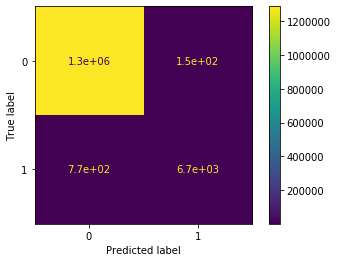

In [29]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X, y)

In [ ]:
predicted

In [45]:
train.shape

(1296675, 50)

In [46]:
model.predict_proba(X).round(3)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [31]:
import scikitplot as skplt
import matplotlib.pyplot as plt

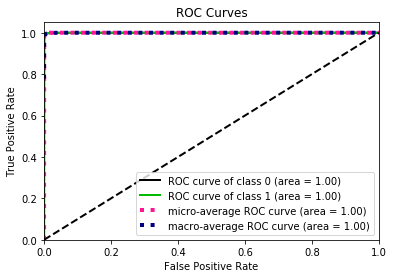

In [33]:
y_true = y # ground truth labels
y_probas = model.predict_proba(X) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_true, y_probas)
plt.show()

In [34]:
y_true

0          0
1          0
2          0
3          0
4          0
          ..
1296670    0
1296671    0
1296672    0
1296673    0
1296674    0
Name: is_fraud, Length: 1296675, dtype: int64

In [56]:
list(y_probas[:,1])

[8.63203e-07,
 2.9546064e-07,
 7.580101e-07,
 0.000113457034,
 1.1082217e-07,
 5.0579565e-06,
 2.4798232e-05,
 2.394152e-06,
 0.0012467579,
 2.856018e-05,
 2.9676312e-05,
 7.5230378e-06,
 3.8063133e-06,
 5.0321296e-06,
 5.4733255e-06,
 2.2821851e-07,
 0.00067632704,
 0.00010217166,
 2.1535123e-05,
 9.120005e-06,
 6.214584e-06,
 4.9930528e-05,
 1.7506582e-05,
 2.064304e-05,
 9.142813e-07,
 8.0771895e-07,
 8.720743e-06,
 0.0012566126,
 4.5264287e-07,
 8.265492e-06,
 3.5538587e-06,
 7.890286e-06,
 2.5273778e-06,
 2.1245676e-06,
 5.040055e-07,
 1.5695012e-05,
 3.018946e-05,
 2.7508526e-05,
 1.8227867e-06,
 0.0017624199,
 3.7418208e-06,
 1.3066131e-06,
 3.1366537e-05,
 0.00016787414,
 8.025384e-06,
 8.640047e-06,
 6.729139e-06,
 9.1970405e-06,
 2.9237335e-06,
 1.8745346e-05,
 7.758134e-06,
 8.8019965e-07,
 4.1125877e-06,
 1.06435455e-05,
 7.5503687e-07,
 0.00688397,
 5.9311988e-06,
 5.9269405e-06,
 7.978903e-05,
 4.8590053e-05,
 2.1122206e-07,
 2.4839437e-06,
 7.369232e-06,
 1.4764249e-05,


In [43]:
y_true

0          0
1          0
2          0
3          0
4          0
          ..
1296670    0
1296671    0
1296672    0
1296673    0
1296674    0
Name: is_fraud, Length: 1296675, dtype: int64

In [57]:
data_tuples = list(zip(y_true,list(y_probas[:,1])))

In [58]:
compare = pd.DataFrame(data_tuples, columns=['y_true','y_probas'])

In [63]:
compare.loc[compare['y_true']==1,:].head(40)

,y_true,y_probas
2449,1,0.996527
2472,1,0.999532
2523,1,0.998445
2546,1,0.997855
2553,1,0.998506
2937,1,0.791366
3527,1,0.993760
3580,1,0.999812
3600,1,0.999454
3671,1,0.999278
